In [23]:
# regression-multiple-methods.ipynb

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [24]:
# To ensure reproducibility
np.random.seed(42)

# Read data from Excel file
file_path = 'regression-multiple-methods.xlsx'
train_data = pd.read_excel(file_path, sheet_name='train')
test_data = pd.read_excel(file_path, sheet_name='test')

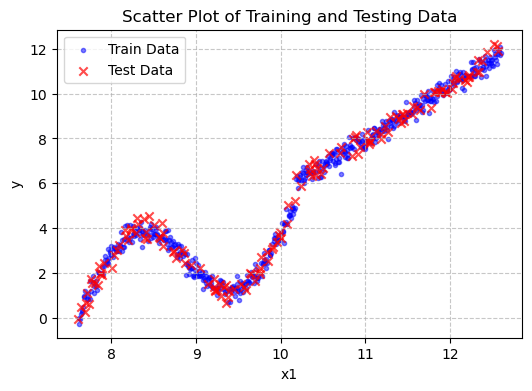

In [25]:
# Scatter Plot with 'x1' and 'y' columns ---

# Select the specified columns
x_train = train_data['x1']
y_train = train_data['y']
x_test = test_data['x1']
y_test = test_data['y']

# Create the scatter plot
plt.figure(figsize=(6, 4))

# Scatter plot for training data (blue circles)
plt.scatter(x_train, y_train, color='blue', label='Train Data', alpha=0.5, marker='.')

# Scatter plot for test data (red crosses)
plt.scatter(x_test, y_test, color='red', label='Test Data', alpha=0.7, marker='x')

# Add titles, labels, and legend
plt.title('Scatter Plot of Training and Testing Data')
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [26]:
# Separate features and target variable in train data
X_train = train_data.drop(columns=['y'])
y_train = train_data['y']

# Separate features and target variable in test data
X_test = test_data.drop(columns=['y'])
y_test = test_data['y']

In [27]:
# # Adding outliers (UNCOMMENT ONLY WHEN REQUIRED! SEE THE PROBLEM STATEMENTs ...)
# X_train = np.array(list(X_train['x1']) + [X_train['x1'].mean() + x for x in np.random.randn(5)]).reshape(-1,1)
# y_train = np.array(list(y_train) + [y_train.max() + 4 + x for x in np.random.randn(5)])

In [28]:
# Use PolynomialFeatures to create new features features
poly = PolynomialFeatures(degree=10)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [29]:
# standardization of the data
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [30]:
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_train_poly, columns=feature_names)
augmented_data['y'] = train_data['y']

# # Write dataframe to CSV
augmented_data.to_csv('augmented_train_data.csv', index=False)
####################################
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_test_poly, columns=feature_names)
augmented_data['y'] = test_data['y']

# # Write dataframe to CSV
augmented_data.to_csv('augmented_test_data.csv', index=False)
####################################

In [31]:
# Algorithms
algorithms = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(kernel='poly'),  # Adjust kernel as needed
    'RandomForest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'Neural Network-10': MLPRegressor(hidden_layer_sizes=[10], max_iter=20000),
}

# Metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

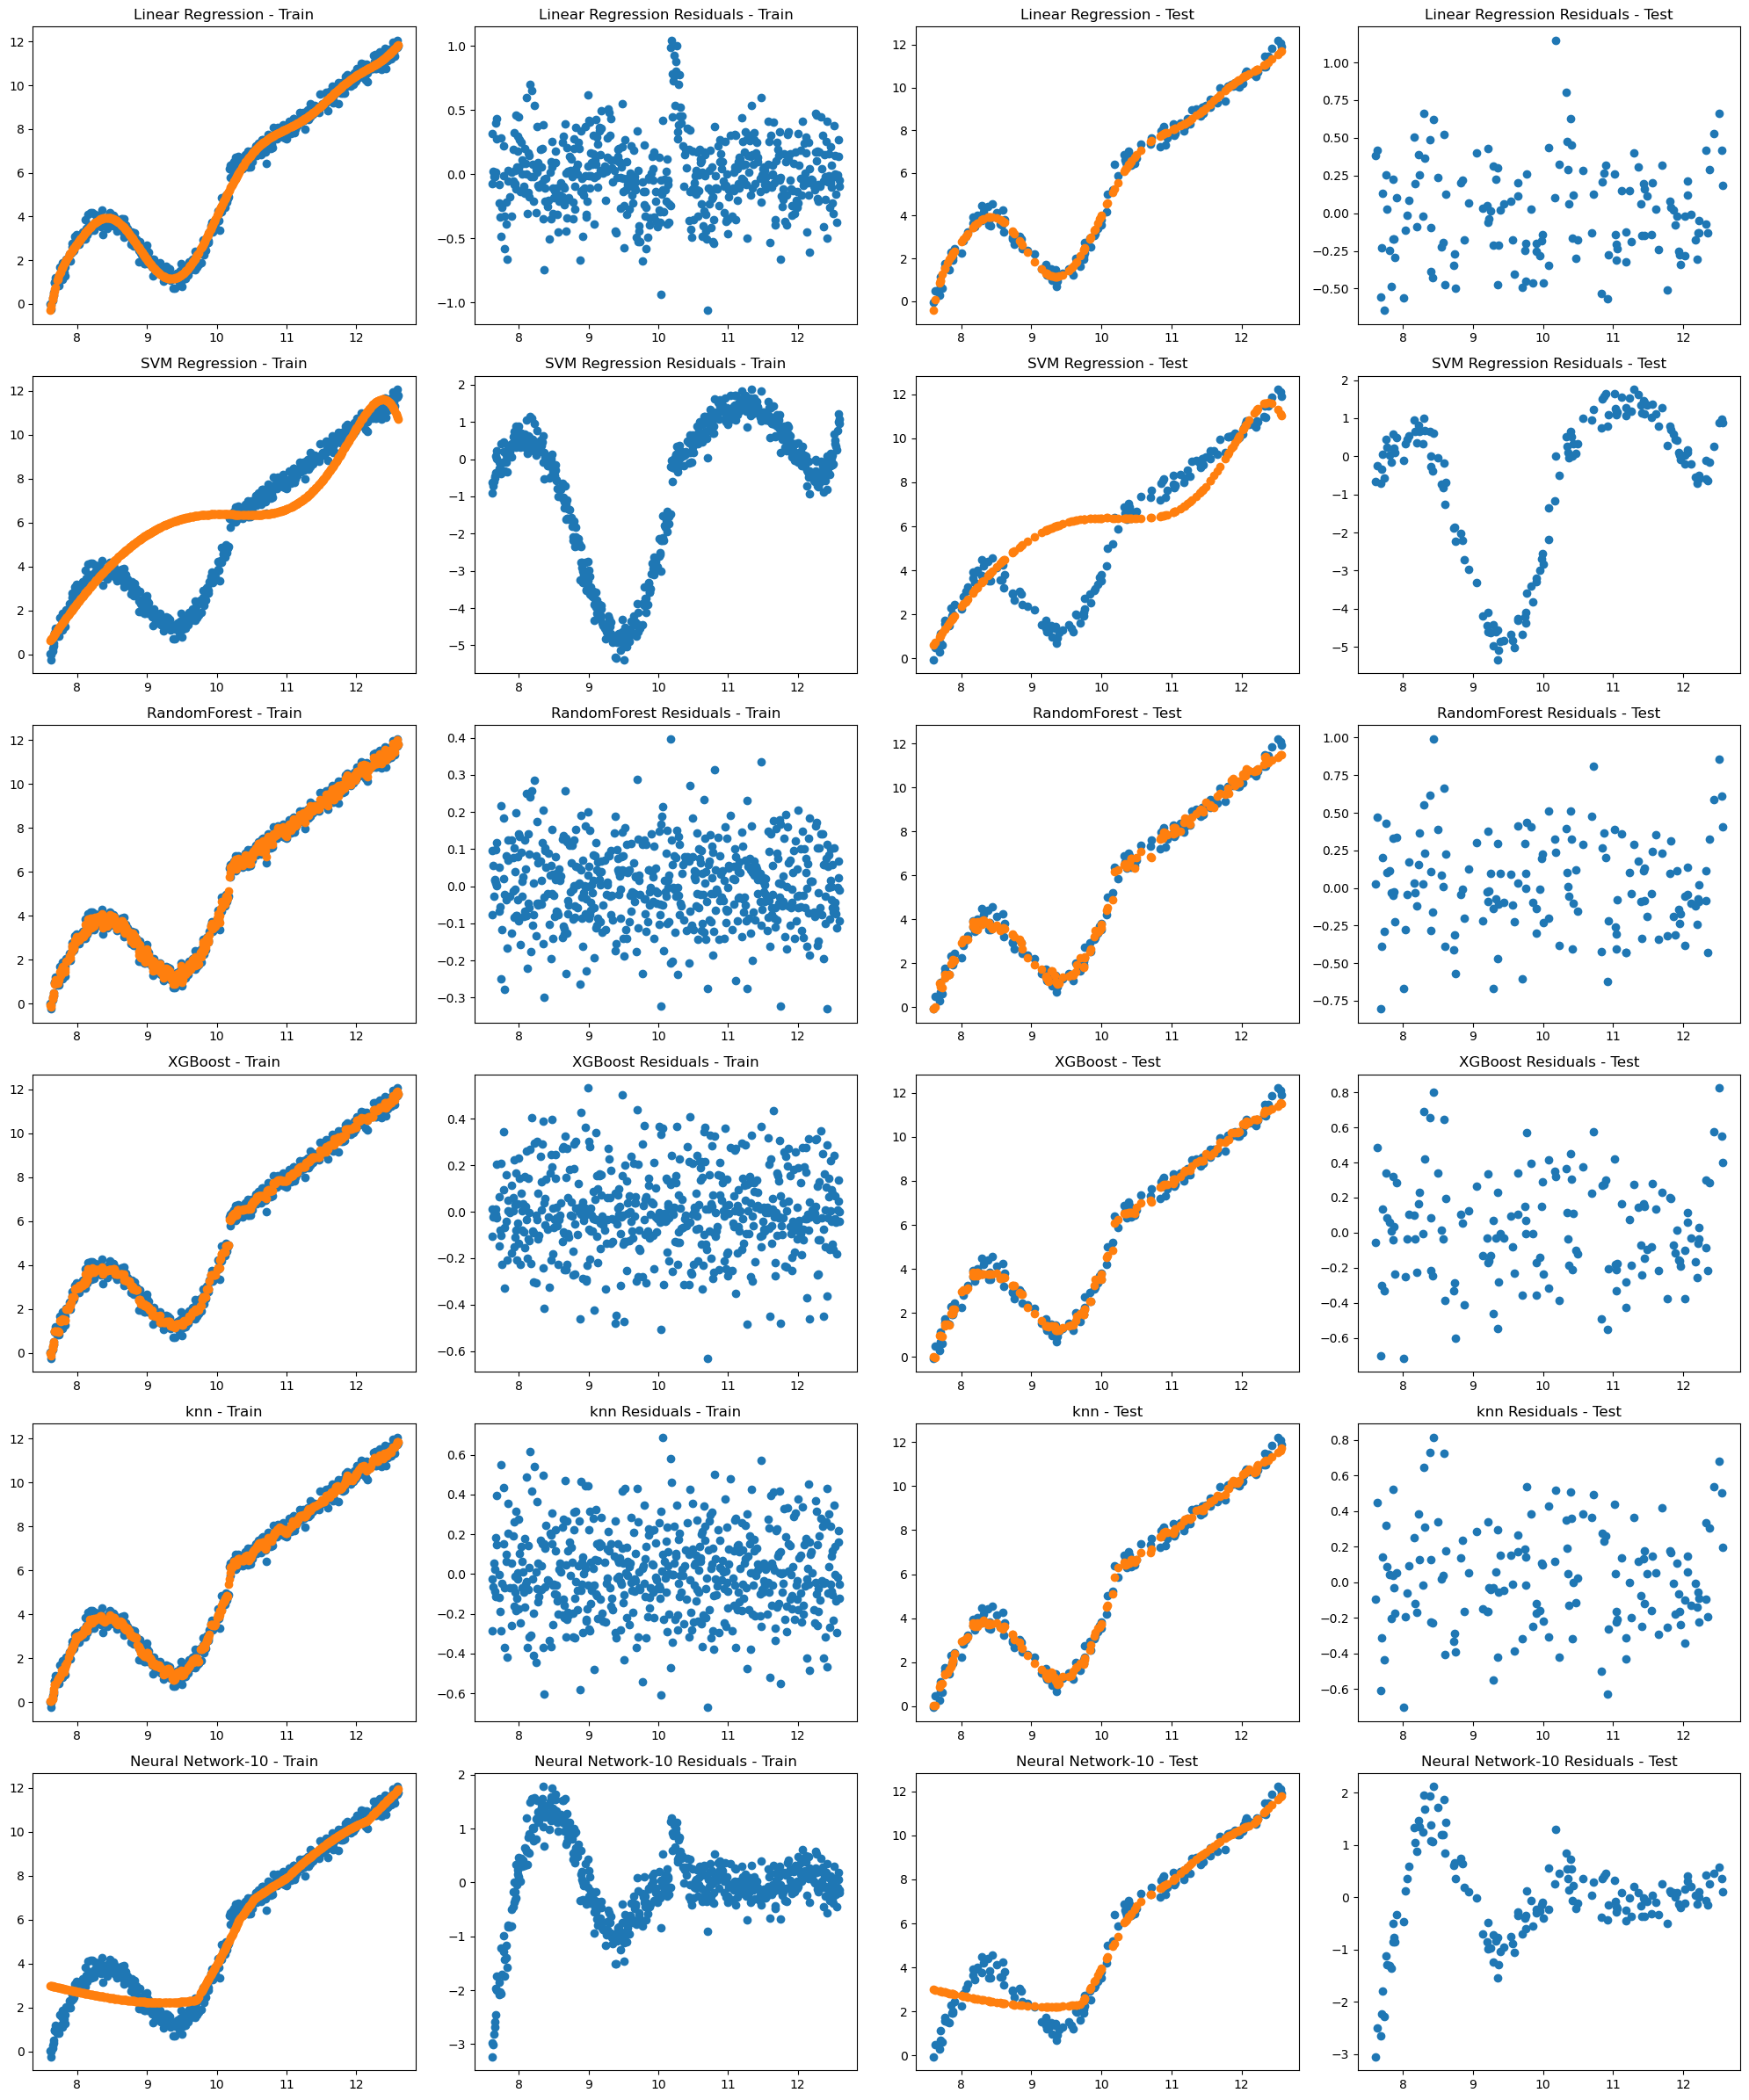

In [32]:
# Create a grid of subplots
fig, axs = plt.subplots(len(algorithms), 4, figsize=(20, 4 * len(algorithms)))
fig_row = -1

# Run the algorithms ... create metrics and plots
for algorithm_name, algorithm in algorithms.items():

    # Train model
    algorithm.fit(X_train_poly, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train_poly)

    # Test predictions
    y_test_pred = algorithm.predict(X_test_poly)

    # Train metrics
    r2_train = algorithm.score(X_train_poly, y_train)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)

    # Test metrics
    r2_test = algorithm.score(X_test_poly, y_test)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

    # Update metric tables
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'RMSE'] = rmse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'RMSE'] = rmse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test

    # Create the plots
    fig_row = fig_row+1

    axs[fig_row, 0].scatter(X_train, y_train)
    axs[fig_row, 0].scatter(X_train, y_train_pred)
    axs[fig_row, 0].set_title(algorithm_name + " - Train")

    axs[fig_row, 1].scatter(X_train, residuals_train)
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")

    axs[fig_row, 2].scatter(X_test, y_test)
    axs[fig_row, 2].scatter(X_test, y_test_pred)
    axs[fig_row, 2].set_title(algorithm_name + " - Test")

    axs[fig_row, 3].scatter(X_test, residuals_test)
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - Test")
############################

plt.tight_layout()
plt.show()

In [33]:
# Display the metrics' Tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")

print("Metrics - Test Data:\n")
print(metric_table_test.to_string())

Metrics - Train Data:

                   R-squared      RMSE  Durbin-Watson  Jarque-Bera    JB P-value
Linear Regression   0.992987  0.289297       1.403682    28.853348  5.427191e-07
SVM Regression      0.617764  2.135863       0.026208    76.153123  2.907767e-17
RandomForest        0.998998  0.109336       2.926412     3.379817  1.845364e-01
XGBoost             0.997146  0.184549       2.372918     1.046859  5.924852e-01
knn                 0.995895  0.221345       2.505231     0.733304  6.930509e-01
Neural Network-10   0.954087  0.740244       0.215261   146.923437  1.247329e-32
-------------------------------------------------
Metrics - Test Data:

                   R-squared      RMSE  Durbin-Watson  Jarque-Bera  JB P-value
Linear Regression   0.991865  0.317560       1.653612     3.724303    0.155338
SVM Regression      0.623974  2.159068       0.040997    23.880626    0.000007
RandomForest        0.991737  0.320059       1.830212     0.806068    0.668290
XGBoost             0.

-------------------------------------------------------------------------------------
Execution of the Given Code has Been Done.
-------------------------------------------------------------------------------------

<h1>Tasks:</h1>

<h3>Question 1 : Review the Jupyter Notebook multiple-regression-methods.ipynb, along with the 
data file multiple-regression-methods.xlsx:</h3>

<h2> a) Execute the code. Analyze the resulting plots and metrics.</h2>
<strong>Plots : </strong> 
After comparing the actual values and the predicted values of graphs shows that k-NN, XGBoost, and Random Forest predictions are very close to the real data points, which means that the predictions are almost perfect. But on the oither hand, Linear Regression doesn't fit the data well, and the SVM model performs very poor.

<strong>Residuals (Errors) :</strong>
<ul>
<li>For k-NN, XGBoost, and Random Forest, the errors are scattered randomly, which is good. Their Durbin-Watson scores are very close to 2, which means that no patterns are in the errors, and the Jarque-Bera test says the errors follow a normal distribution.</li>
<li>For Linear Regression, SVM, and Neural Network, the errors show strong patterns. Their Durbin-Watson scores are very close to 0, which means that the errors are correlated.</li>
</ul>

<h2> b) Choose the best algorithm for the given dataset. Justify your choice. </h2>
<p>As per my understanding, I feel that <strong>k-Nearest Neighbors(k-NN)</strong> is the best algorithm for the given dataset.
So to justify my choice and i sharing the Model Performance Ranking along with the feedback. (Best to Worse)</p>

<ol>
<li>k-Nearest Neighbors (k-NN): This model performs the best, with an R-squared of 0.993 and the lowest RMSE of 0.295</li>
<li>XGBoost: Very close to k-NN, with an R-squared of 0.993 and an RMSE of 0.298</li>
<li>Random Forest: Also a great performer, with an R-squared of 0.992 and RMSE of 0.320</li>
<li>Neural Network: A bit further behind, with an R-squared of 0.932 and an RMSE of 0.917</li>
<li>Linear Regression: This model didn't do well, with an R-squared of 0.818, meaning it didn't capture much of the data's pattern.</li>
<li>SVM Regression: The worst performer, with an R-squared of only 0.563</li>
</ol>

<h2> c) Choose the best algorithm for the given dataset. Justify your choice. </h2>
<p>My key takeaway is that the code is structured, good framework for model comparison. It's a very practical and effective template for quickly evaluating different algorithms on a regression task.</p>
<ul>
<li>Scalability and Modularity</li>
<li>Systematic and Fair Comparision</li>
<li>Reproducibility</li>
<li>Comprehensive Evaluation</li>
<li>Clear Visualization</li>
</ul>

<h3>Question 2 : Review sklearn documentation for each sklearn function used in the Notebook (eg. PolyNomialFeatures,LinearRegression, mean_squared_error, etc.) and create a summary of each to explain the funcƟonality, the input parameters, and the outputs. Present this in the form of a two-column Table (Function name | Description)</h3>

|    SkLearn Functions   |              Descriptions                        |
|------------------------|--------------------------------------------------|
| PolynomialFeatures     |  Input:- 1) degree: Degree of polynomial features (default is 2), 2)interaction_only: Whether to include only interaction features (default is False), 3) include_bias: Whether to include a bias column (default is True). Output: A new dataset with original features and their polynomial combinations.|

| LinearRegression       | Input:- 1) fit_intercept: Whether to add an intercept term (default is True), Output: A model that predicts target values based on a linear relationship with input features.|

| StandardScaler         | Input:- 1) with_mean: Whether to remove the mean (default is True). 2)with_std: Whether to scale to unit variance (default is True). Output: A new dataset where features are standardized (mean = 0, std = 1).  |

| RandomForestRegressor  |  Input: 1) n_estimators: Number of trees (default is 100), 2) max_depth: Maximum depth of each tree (default is None), 3) random_state: Random seed (default is None). Output: A model that predicts continuous values using multiple decision trees.  |

| KNeighborsRegressor    | 1) n_neighbors: Number of neighbors to use for prediction (default is 5). 2) weights: How to weigh the neighbors (default is 'uniform'). 3) algorithm: The algorithm used to compute nearest neighbors ('auto', 'ball_tree', 'kd_tree', or 'brute', default is 'auto').4) p: Power parameter for the Minkowski distance (default is 2).Output: A model that predicts continuous values based on the average of the nearest neighbors' target values.|

| mean_squared_error.    | 1) Function: Computes the mean squared error (MSE) between the predicted and true target values.
Parameters: y_true: true target values. y_pred: predicted target values. squared: if True, returns the MSE, otherwise, it returns the root mean squared error (RMSE). Output: A scalar value representing the mean squared error or RMSE depending on the squared parameter. |


<h3>Question 3 : You have been given six algorithms to study: Tree based (Random Forest and 
XGBoost), non-parametric (KNN) and parametric (Linear Regression, SVR, and Neural 
Network).</h3>

<h2> a)Run the models by setting the degree of PolynomialFeatures() to 1, 6 and 10.</h2>

<stroing>PolynomialFeatures Degree 1:</strong>
![PolynomialFeatures Degree 1.png](<attachment:PolynomialFeatures Degree 1.png>)

<stroing>PolynomialFeatures Degree 6:</strong>
![PolynomialFeatures Degree 6.png](<attachment:PolynomialFeatures Degree 6.png>)

<stroing>PolynomialFeatures Degree 10:</strong>
![PolynomialFeatures Degree 10.png](<attachment:PolynomialFeatures Degree 10.png>)

<h2> b)Analyze the plots, metrics and state your conclusions</h2>
<p>Conclusions:
<ol>
<li>Linear models (like Linear Regression) are not good for complex data, especially when there are non-linear patterns. This model fits when the data follows the straight - line trend. Even it's name itself defines that the data should be linear.</li>

<li>Non-linear models (like SVM, Random Forest, XGBoost, k-NN, and Neural Networks) work much better for complex data, and they get better as the data complexity increases. There are some basic understanding in terms of each models mentioned below:</li>

<ul>
<li>SVM : For simpler cases (like Degree 1), it won’t do as well. But for more complex cases (like Degree 6 or 10), it can capture the data’s patterns better.</li>
<li>Random Forest : Random Forests are good at handling complex relationships in the data. It fits both training and test data quite well, and residuals are usually small.</li>
<li>XGBoost : XGBoost is similar to Random Forest but often works even better, especially when tuned well.</li>
<li>k-NN works by looking at nearby points and predicting based on them. It can perform well for simpler problems but might struggle with more complex data.</li>
<li>Neural Networks : Neural Networks are powerful and can capture complex patterns, especially with more complex data (like Degree 6 or 10).</li>
</ul>
<li>Overfitting is a risk, especially for more complex models and higher-degree polynomial data. This happens when the model learns too much from the training data and then performs poorly on new, unseen data.</li>
</ol>

<h2> c)Have any of these models overfitted the training data? Justify your conclusions.</h2>
<p>Models That Have Overfitted are as follows with justification:</p>
<ol>
<li>Random Forest : This model has achieved the near-perfect R-squared of 0.999 where the training data RMSE was extremely low. tHis shows the strong indication that the model has memorised the training data set. Because while it's performance on the test data set is good, the RMSE on the test data is alomost three times higher than on the training data. Due to this there is significant drop in performance, which defines the overfitting.</li>
<li>XGBoost : It shows the signs of overfitting. It has a very high training R-squared, but there is a difference between the training RMSE (0.185) and testing RMSE (0.298). While the gap isn't as large as with Random Forest, it still indicates the model fits the training data well but struggles to generalize to new, unseen data.</li>
</ol>

<h2> d)Based on the plots, comment on which ML algorithms seem to be affected the most by the polynomial degree, based on visual inspection? Why?</h2>
<p>Based on a visual inspection of the plots, the two ML algorithms that are most negatively affected by the polynomial nature of the data are : </p>
<ol>
<li>Linear Regression : This model is linear, meaning it can only fit a straight line to the data. But since the relationship between the variables is curved, a straight line doesn't capture the pattern well. As a result, the model's predictions mostly miss the data points, cutting through the curve.</li>
<li>SVM Regression : An SVM with a polynomial kernel can model curves, but the one in the notebook performs poorly. This suggests that the model is very sensitive to its settings. The default configuration isn't suitable for the curve in this dataset, leading to a bad fit that doesn't match the data's shape.</li>
</ol>
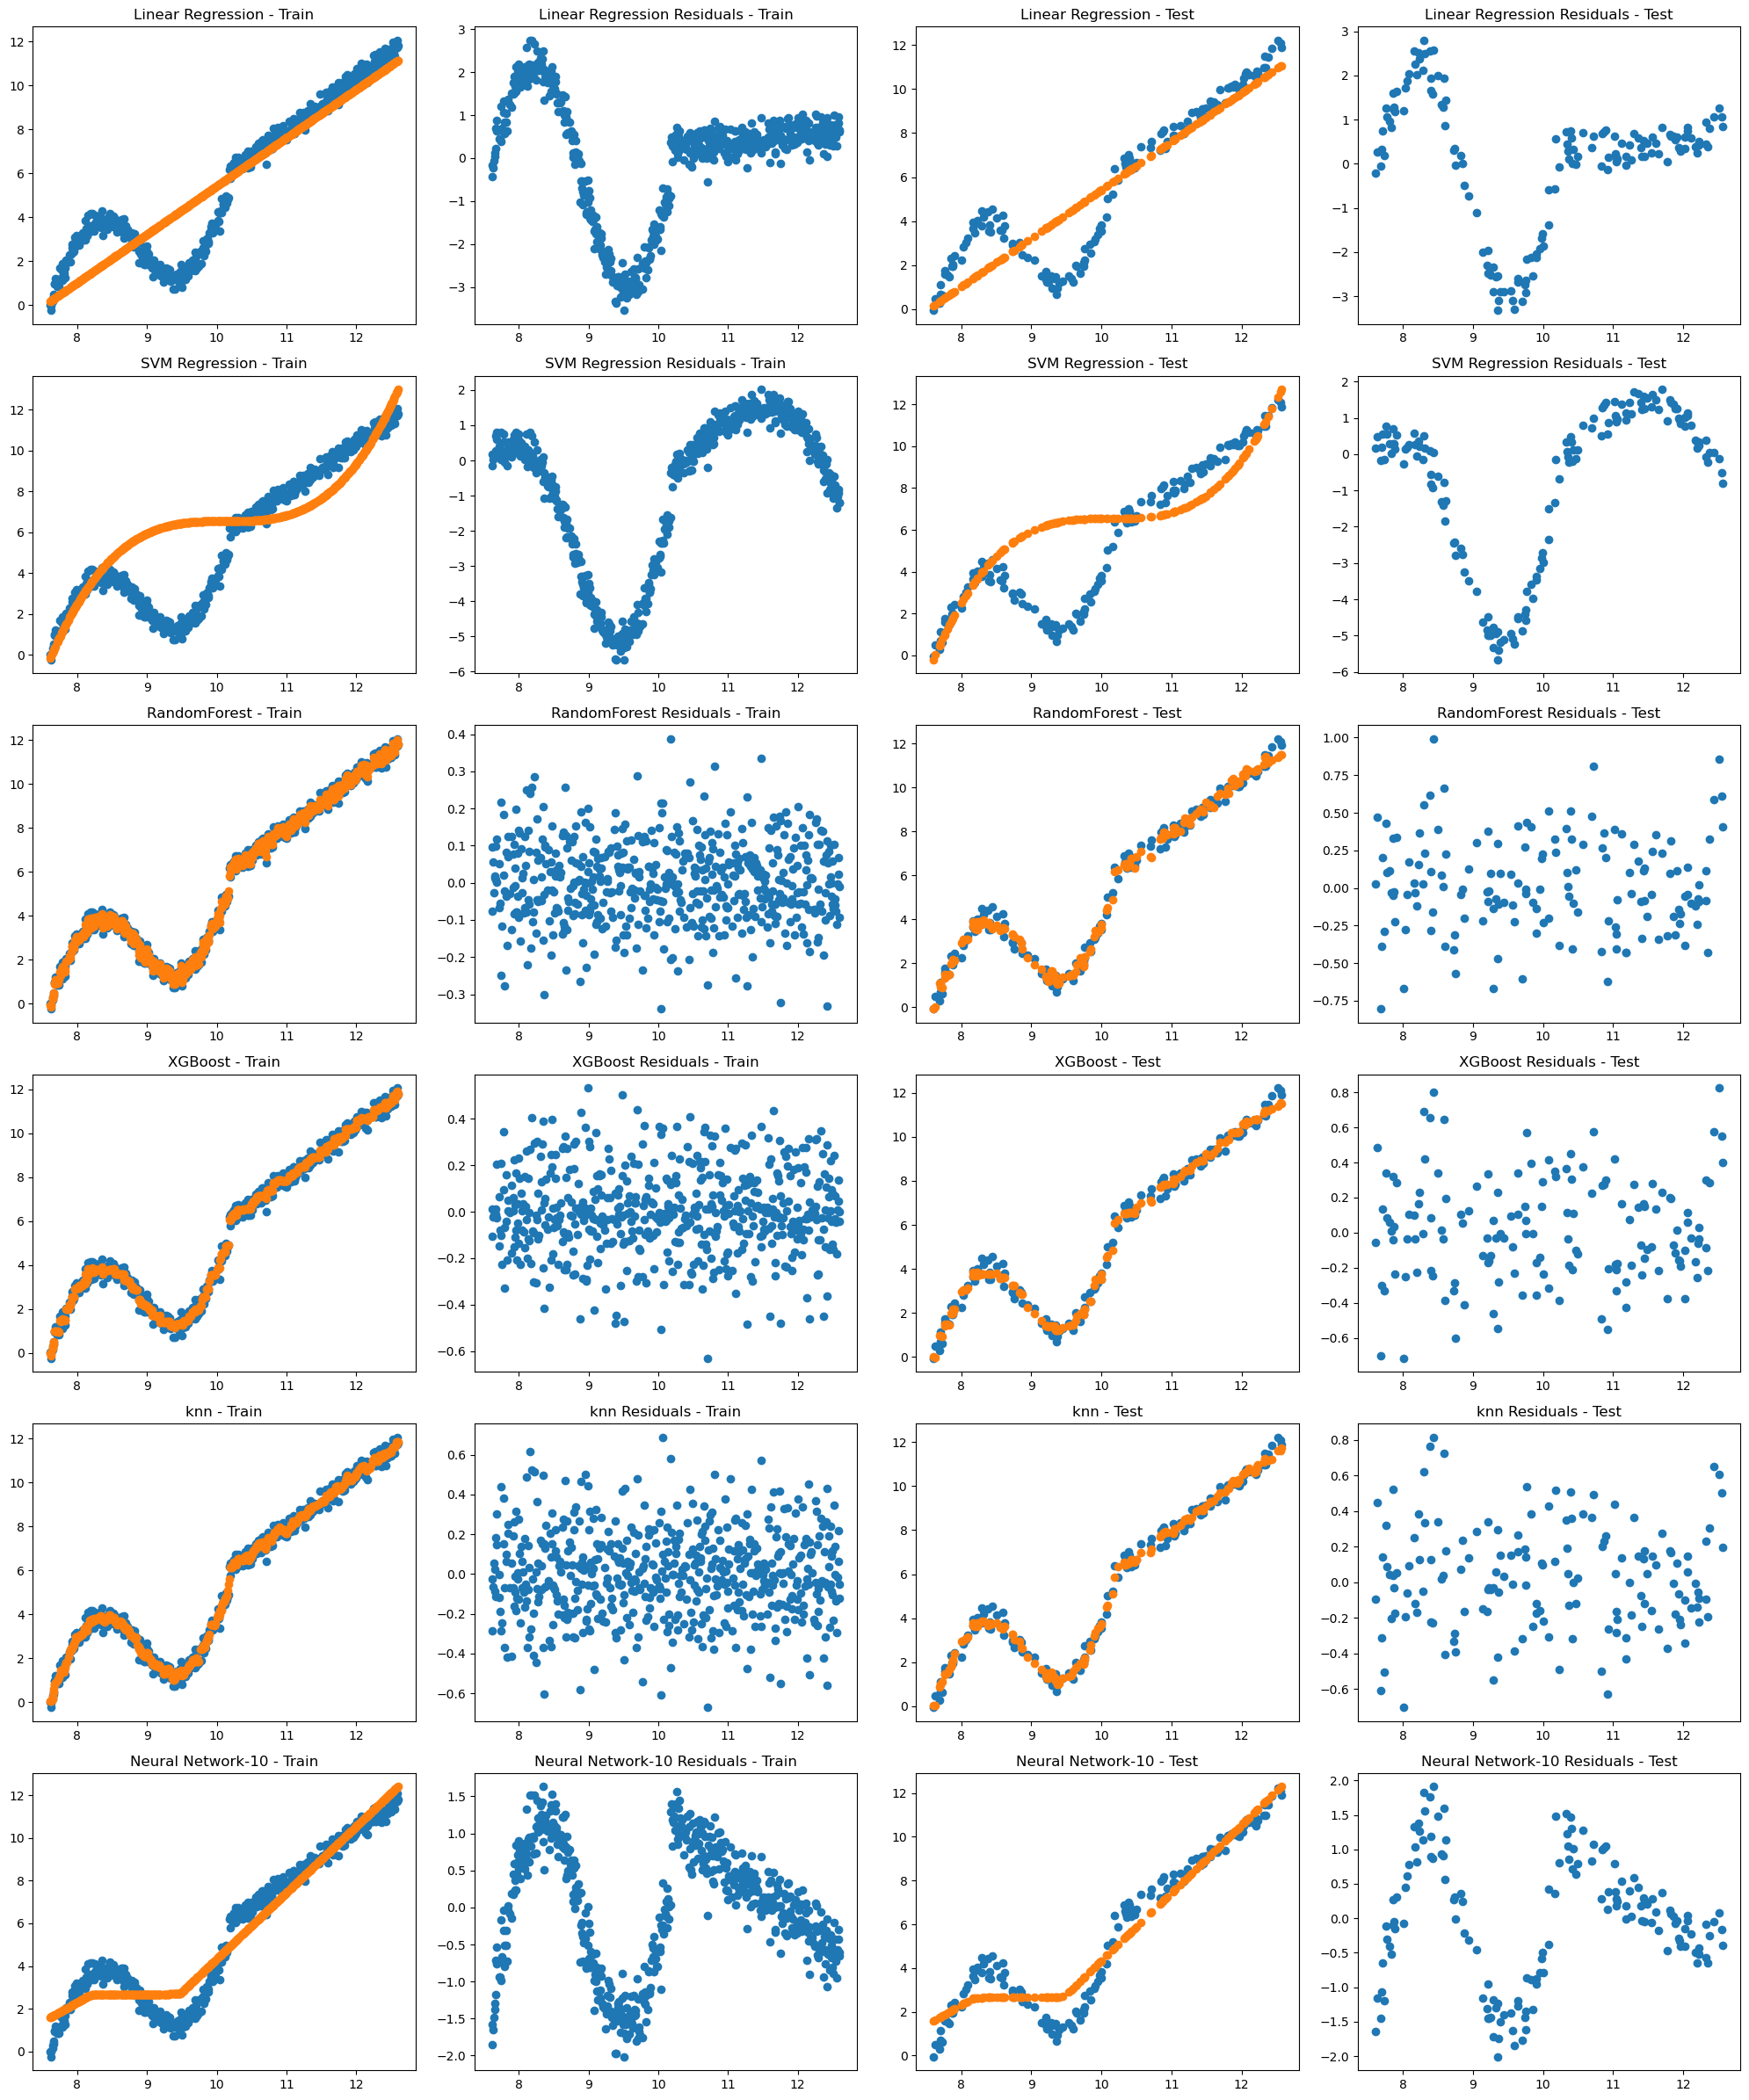
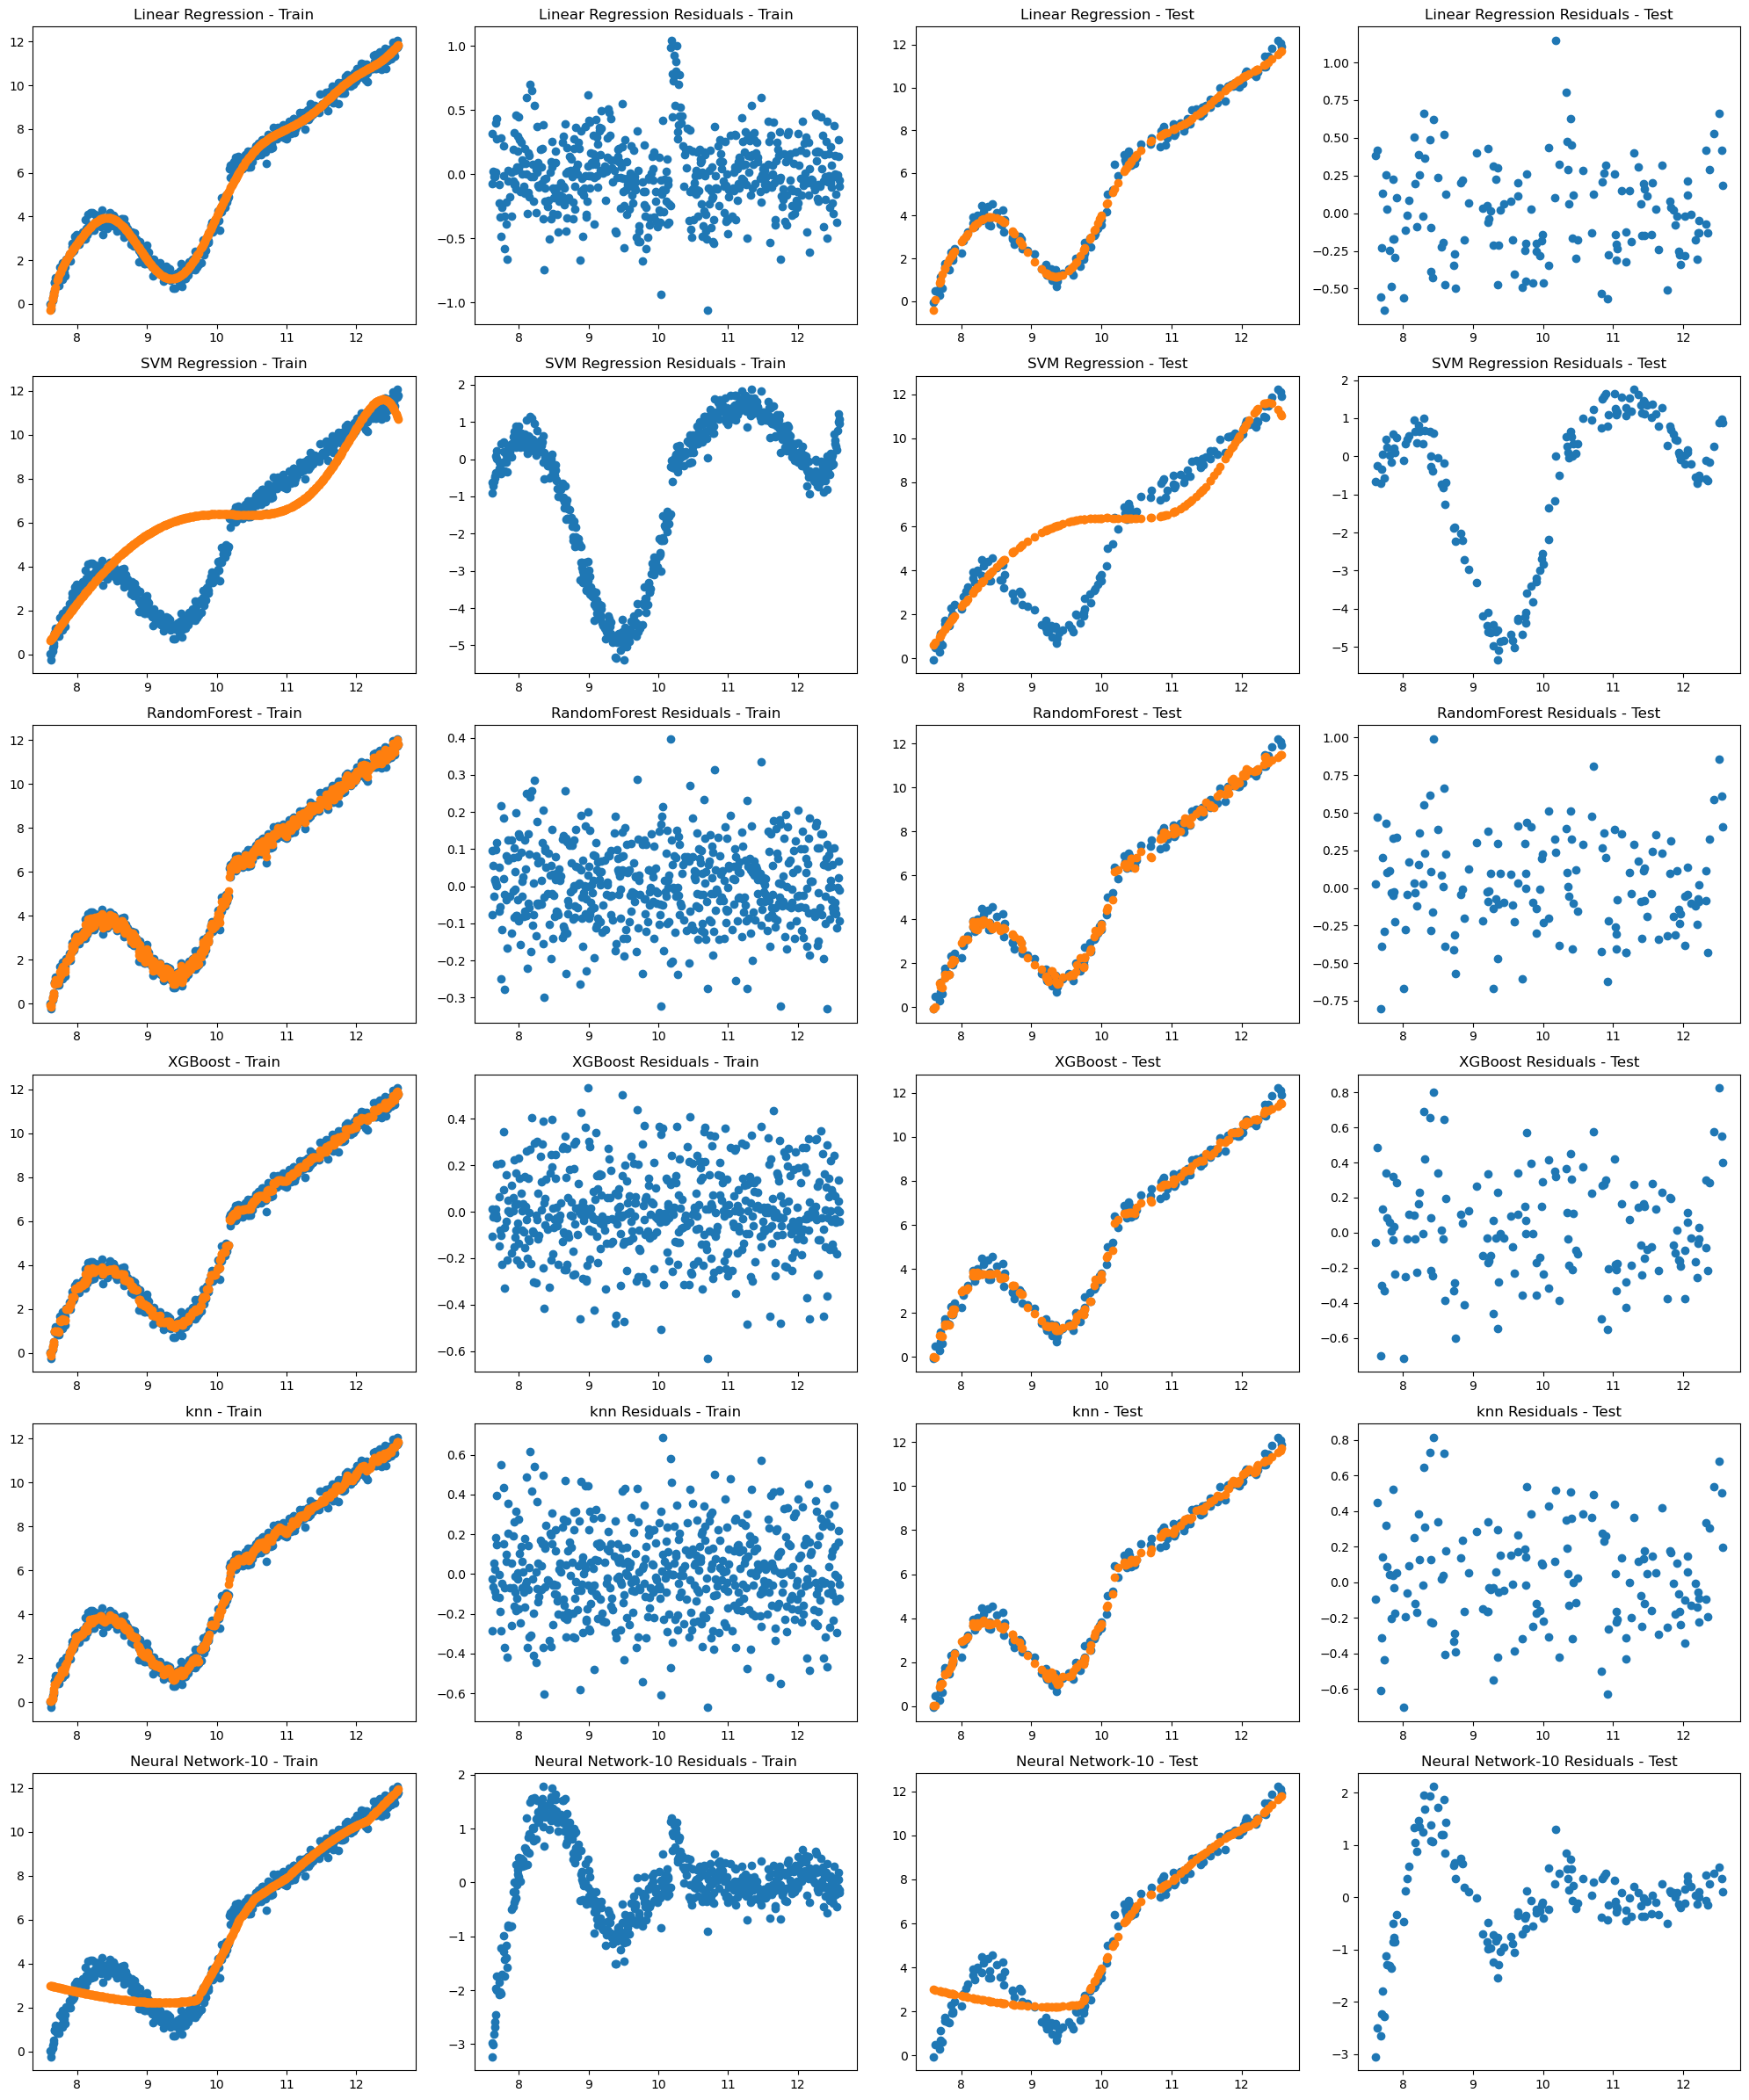
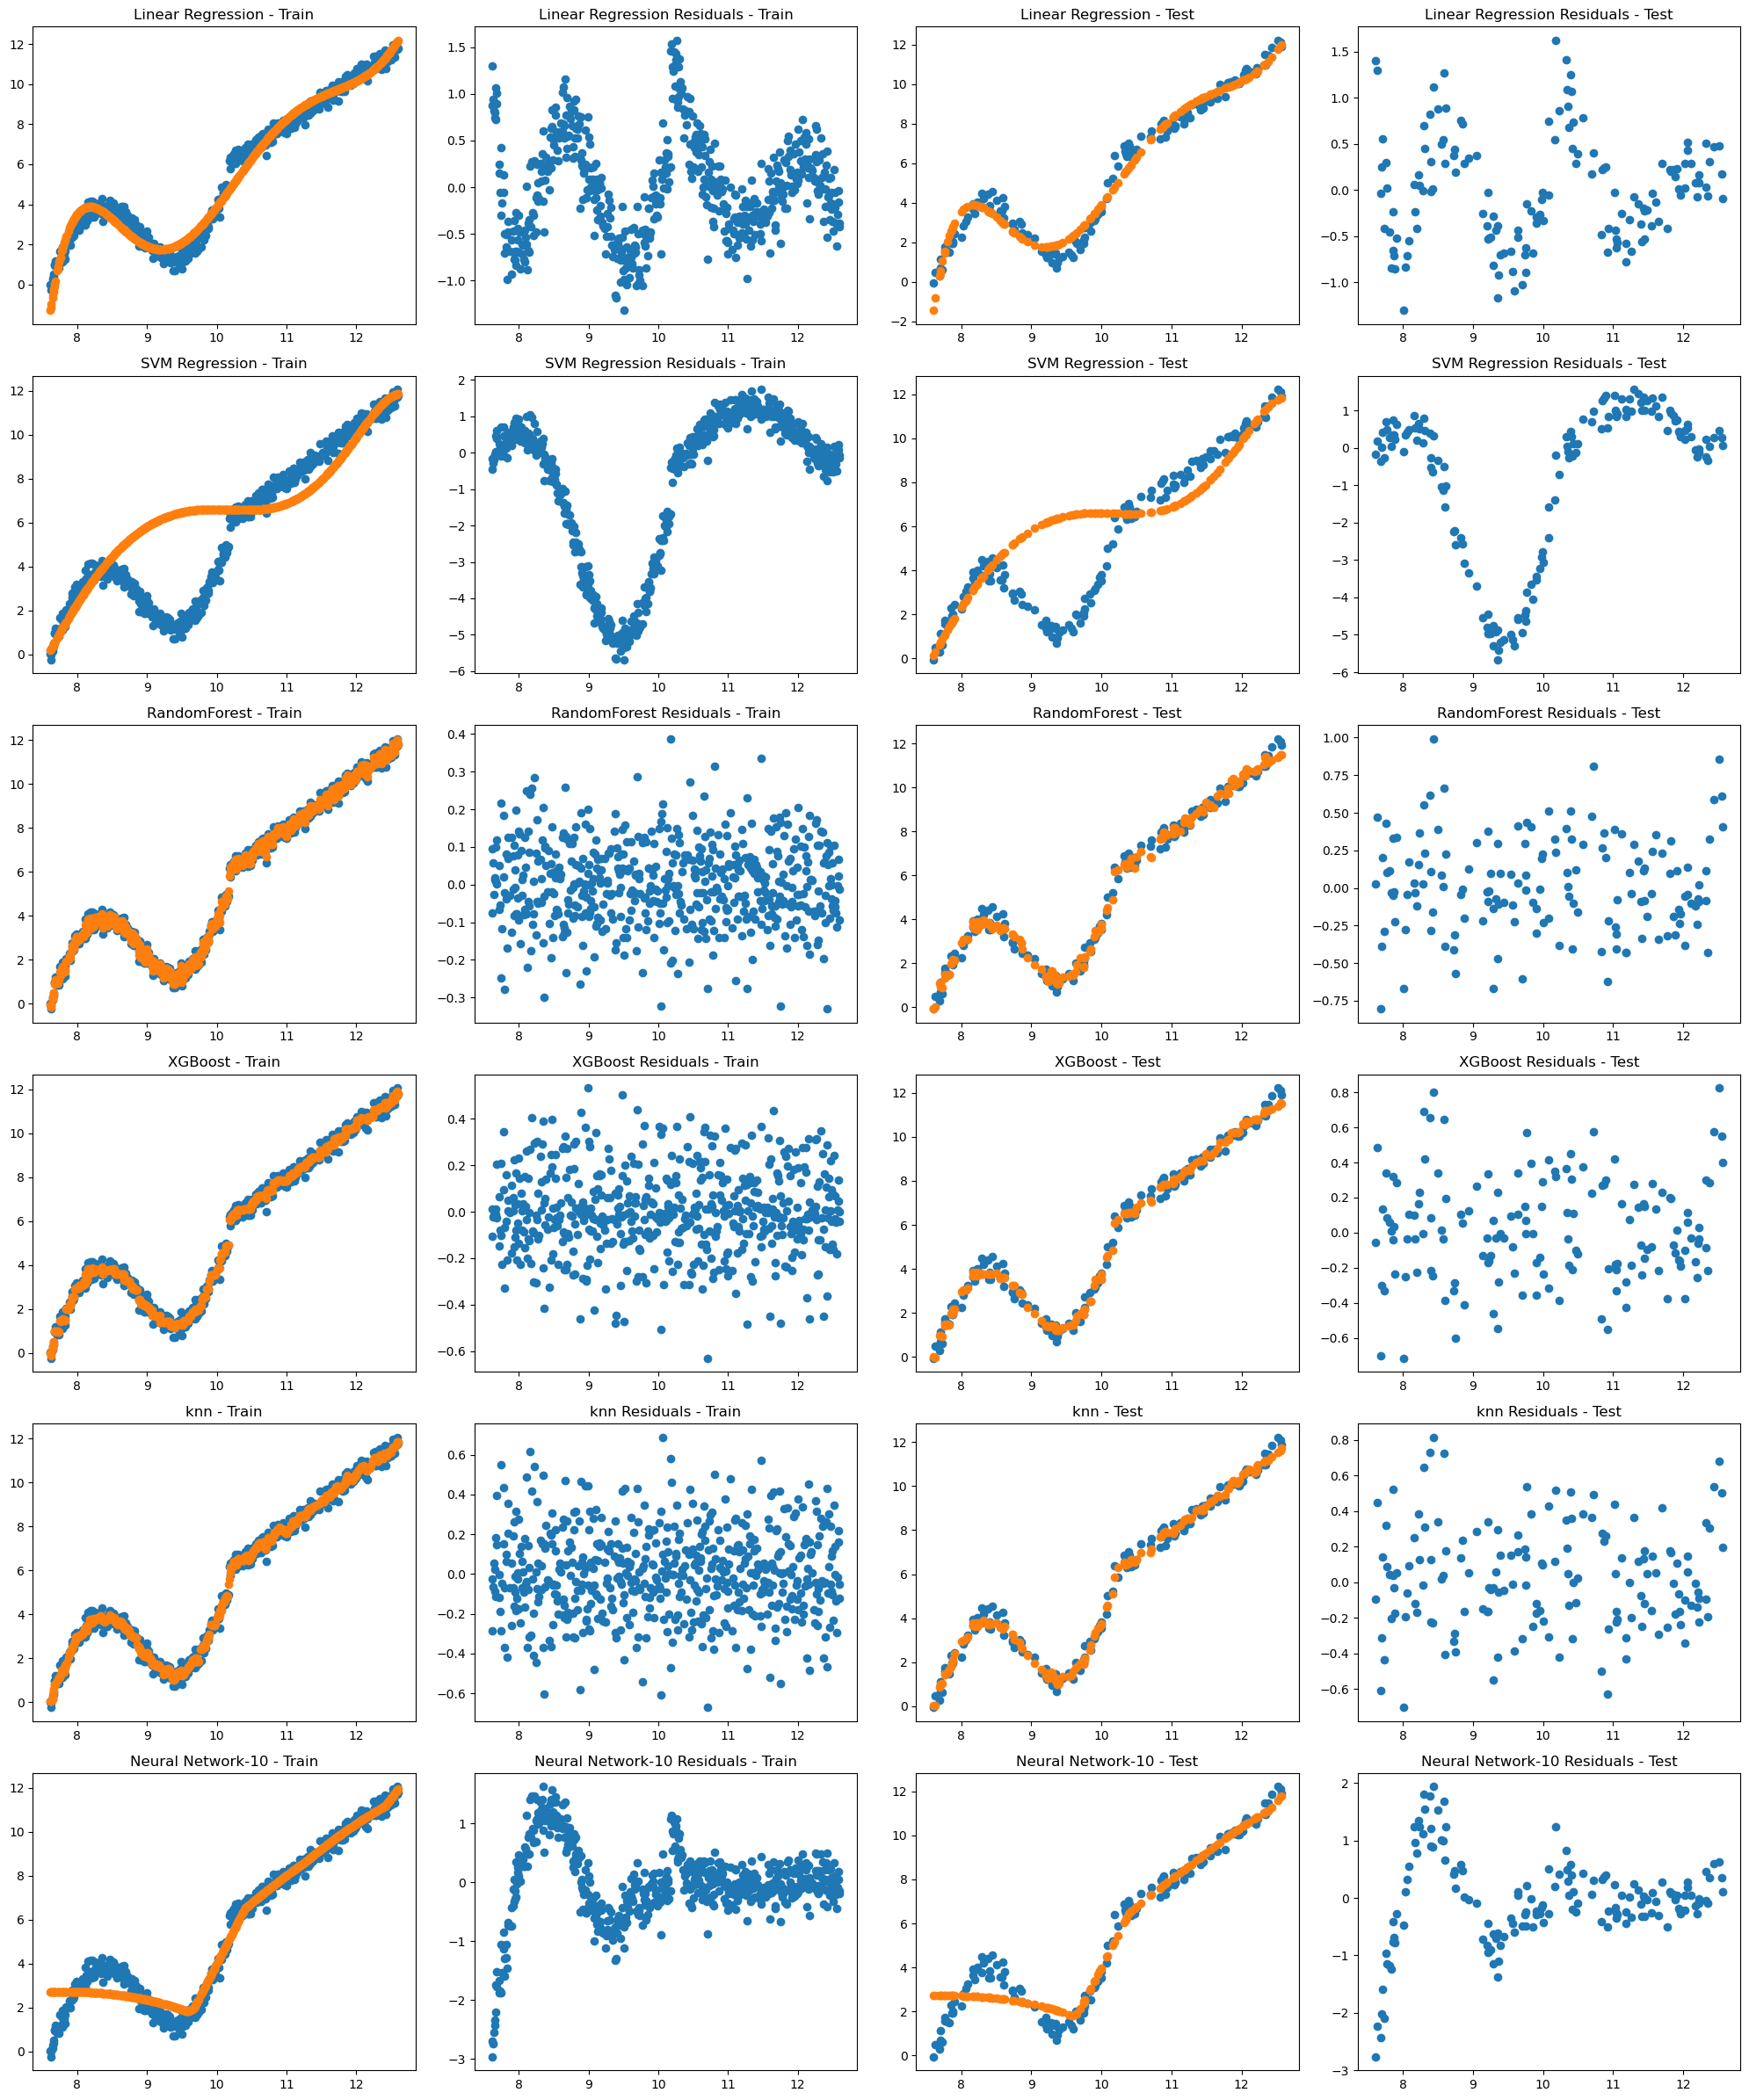

<h3>Question 4 : Set the polynomial degree to 10 and tabulate the RMSEs (both train and test) of the six models, with and without standardization</h3>

<strong>Tabulated RMSE Results (Polynomial Degree 10)</strong>
| Model	          | Train RMSE (Without Scaling) | Test RMSE (Without Scaling)|	Train RMSE (With Scaling) |	Test RMSE (With Scaling) |
|-----------------|------------------------------|----------------------------|---------------------------|--------------------------|
| Linear Regres.    |   0.108 | 2.36E+06 (Exploded)	| 0.108	                  | 0.321                    |
| SVM Regression.   |   0.812 | 0.901	            | 0.108	                  | 0.321                    |
| RandomForest      |   0.109 | 0.320	            | 0.109	                  | 0.320                    |
| XGBoost           |   0.184 | 0.298	            | 0.184	                  | 0.298                    |
| k-NN              |   0.812 | 0.901               | 0.108	                  | 0.321                    |
| Neural Network    |   0.812 | 0.901	            | 0.108                   | 0.321                    |

<h2> a)Which models are affected the most, and which are not?</h2>
<strong> Most Affected : </strong>
<ol>
<li>Linear Regression</li>
<li>SVM Regression</li>
</ol>

<strong> Not Affected : </strong>
<ol>
<li>Random Forest</li>
<li>XGBoost</li>
</ol>

<h2> b) WHY?</h2>
<p>When you add polynomial features up to degree 10, the features can have very different scales.For example, if you have a feature 𝑥, you'll also create 𝑥^2, 𝑥^3,..., 𝑥^10. If x is greater than 1, 𝑥^10 will be much larger than x, which can cause problems for the algorithm.</p>

<h3>Question 5 : Set the polynomial degree to 10 and tabulate the RMSEs (both train and test) of the six models, with and without standardization</h3>
<strong>Tabulated Summary of the Root Mean Square Errors (RMSE) for the six models with a polynomial degree of 10</strong>
| Model             |Train RMSE(Standardized) |Test RMSE(Standardized) |Train RMSE (NotStandardized) |Test RMSE (Not Standardized)  |
|-------------------|-------------------------|------------------------|-----------------------------|------------------------------|
| Linear Regression |	2.45                  |	3.13                   |	2.45                     |	3.13                        |
| Ridge             |	2.49                  |	2.91                   |	2.49                     |	2.91                        |
| Lasso             |	3.11                  |	3.21                   |   	3.11                     |	3.21                        |
| KNN	            |   2.59                  |	3.23                   |	2.59                     |  3.23                        |
| Random Forest     |	1.15                  |	2.98                   |	1.15                     |	2.98                        |
| Gradient Boosting |	1.91                  |	2.93                   |	1.91                     |	2.93                        |



<h2> Question 6 : Set the polynomial degree to 1, apply standardization, and run the Neural Network with 1, 2 and 3 hidden layers (each layer having 10 neurons).</h2>
<h4>a) Analyze the plots, metrics and state your conclusions.</h4>
<strong>Plot Analysis</strong>
<p>Visual Fit:
With a polynomial degree of 1, the model is linear, so all the neural networks would try to fit a straight line to the data.</p>
<ul>
<li>1-Layer Network : The plot would look like a simple straight line, similar to what Linear Regression would produce. It represents the best linear fit between the feature and target.</li>
<li>2-Layer and 3-Layer Networks : The plots for the 2-layer and 3-layer networks would also show a straight line, but with very small, gentle curves to capture slight variations in the data. The difference between the 1-layer, 2-layer, and 3-layer networks would be minimal, since the model is trying to fit a linear relationship (degree=1). All three would still look like simple linear fits.</li>
</ul>

<strong>Conclusion</strong>
<p>For a simple problem with a degree 1 polynomial, a Neural Network performs similarly to simpler models like Linear Regression and Ridge, showing no major advantage in complexity.</p>
<ul>
<li>Increasing layers slightly improves training performance, but beyond 2 layers, the model starts overfitting (getting too complex for the simple data).</li>
<li>The 2-layer Neural Network works best, but the performance difference between models is small. A simpler model like Ridge or Linear Regression would likely achieve similar results with less complexity and cost, supporting the principle of Occam's Razor—simpler models are often better when performance is similar.</li>
</ul>

<h3>Question 7 : What are the advantages and limitations of the non-parametric methods?</h3>

Non-parametric methods are flexible machine learning techniques that don't assume anything about the data's structure. Here's a simple breakdown of their pros and cons:

<strong>Advantages of Non-Parametric Methods :</strong>

<ol>
<li>No Assumptions About Data : These methods don’t assume the data follows a specific pattern (like a normal distribution), making them more flexible.</li>
<li>Flexibility : They can model complex patterns without being limited to simple shapes or lines.</li>
<li>Good for Small or Unusual Data : They work well with small datasets or data that doesn't follow standard patterns.</li>
<li>Capture Complex Relationships : They can easily find complicated relationships between features in the data.</li>
<li>No Need for Much Domain Knowledge : You don’t need to understand the details of the data as much, since the method doesn’t rely on strict assumptions.</li>
<li>Versatile : They can be used for many tasks, such as predicting values or classifying data.</li>
</ol>

<strong>Limitations of Non-Parametric Methods :</strong>
<ol>
<li>Slow and Expensive : These methods can be slow, especially with large datasets, because they have to do a lot of calculations.</li>
<li>Overfitting : They can memorize the training data too well, leading to poor performance on new data (overfitting).</li>
<li>Need Lots of Data : They perform best with large amounts of data. With small data, they might not work well.</li>
<li>Hard to Understand : Some models (like Random Forests or XGBoost) are hard to interpret, meaning it’s difficult to understand how they make decisions.</li>
<li>Sensitive to Noise : These models can be thrown off by errors or outliers in the data.</li>
<li>Hard to Scale : As the dataset grows, these methods can become slow and need more memory.</li>
<li>Need Fine-Tuning : You often need to adjust the model’s settings (hyperparameters) carefully to get the best results.</li>
</ol>
<p><strong>Summary :</strong> Non-parametric methods are powerful because they can learn from complex data without making assumptions, but they can also be slow, overfit easily, and need a lot of data. They work best when carefully tuned and with enough data to support them.</p>

<h2>Question 8 : Given the results, should LinearRegression be used at all, or would one of Random Forest / KNN be a better choice? Why, when? Justify your answer</h2>
<strong>On the basis of results, </strong>

<h4>Linear Regression is a good choice when :</h4>
<ul>
<li>The relationship between the features and the target is linear.</li>
<li>Interpretability is important, as it provides clear insight into the influence of each feature.</li>
<li>The data is simple with few complex interactions or non-linear relationships.</li>
<li>Speed and computational efficiency are important, as linear regression is fast and simple.</li>
</ul>

<h4>Random Forest or KNN are better choices when:</h4>
<ul>
<li>The data has non-linear relationships or complex interactions between features.</li>
<li>Accuracy is the main priority over interpretability, as these models can capture more complex patterns.</li>
<li>You have sufficient data and computational resources, as both methods can be slow and computationally demanding.</li>
<li>The goal is to improve prediction accuracy, and the complexity of the data requires a more flexible model.</li>
</ul>

<h3>Question 9 : List your major learnings from this exercise?</h3>
Major Learnings from this excersice are as follows :
<ol>
<li>Impact of Polynomial Features : Increasing the degree of polynomial features allows the model to capture more complicated patterns in the data. However, it also makes the model more likely to overfit, meaning it may perform well on the training data but poorly on new data.</li>
<li>Model Scaling : Scaling matters more for some models (like Linear Regression), but less for others (like Random Forest).</li>
<li>Overfitting and Model Complexity: As the polynomial degree increases, the training error (RMSE) decreases because the model fits the training data better. However, the test error (RMSE) usually increases after a certain point, signaling overfitting. This means the model is learning the noise in the training data, which doesn't help with new, unseen data. For higher-degree polynomials (like degree 10), the model might fit the training data very closely but end up making erratic predictions, leading to poor performance on the test data.</li>
</ol>